https://www.kaggle.com/pranavraikokte/covid19-image-dataset

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import importlib
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
# Step 1: Loading in Dataset
ds_directory = '/home/zrarnz/9-Projects/ECET380/IntelImageSceneClassification/train'
os.listdir(ds_directory)
ts_directory = '/home/zrarnz/9-Projects/ECET380/IntelImageSceneClassification/test'

In [3]:
# Load in ordered dataset
BATCH_SIZE = 16
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)
train_set = image_dataset_from_directory(ds_directory,
                        shuffle=True,
                        validation_split=0.2,
                        subset="training",
                        seed=123,
                        batch_size=BATCH_SIZE,
                        image_size=IMG_SIZE,
                        labels="inferred",
                        label_mode='int')


Found 14034 files belonging to 6 classes.
Using 11228 files for training.


In [4]:
val_set = image_dataset_from_directory(ds_directory,
                        shuffle=True,
                        validation_split=0.2,
                        subset="validation",
                        seed=123,
                        batch_size=BATCH_SIZE,
                        image_size=IMG_SIZE,
                        labels="inferred",
                        label_mode='int')

Found 14034 files belonging to 6 classes.
Using 2806 files for validation.


In [5]:
test_set = image_dataset_from_directory(ts_directory,
                        shuffle=True,
                        batch_size=BATCH_SIZE,
                        image_size=IMG_SIZE,
                        labels="inferred",
                        label_mode='int')

Found 3000 files belonging to 6 classes.


In [6]:
train_set.class_names

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [7]:
# dataset_size = 181
# batch_size = BATCH_SIZE

def preprocess(image, label):
    # resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.efficientnet.preprocess_input(image)
    return final_image, label

train_set = train_set.shuffle(1000)
train_set = train_set.map(preprocess).prefetch(1)
val_set = val_set.map(preprocess).prefetch(1)
test_set = test_set.map(preprocess).prefetch(1)

In [8]:
print('Number of fullset batches: %d' % tf.data.experimental.cardinality(train_set))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_set))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_set))

Number of fullset batches: 702
Number of validation batches: 176
Number of test batches: 188


In [9]:
base_model = tf.keras.applications.EfficientNetB0(input_shape=IMG_SHAPE,
                                                  input_tensor=None,
                                               include_top=False,
                                               pooling=None,
                                                classes=1000,
                                               weights='imagenet')

In [10]:
for layer in base_model.layers:
    layer.trainable = False

avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(
    units = 6, 
    activation = "softmax")(avg)

model = keras.models.Model(
    inputs = base_model.input,
    outputs = output)

model.compile(
    optimizer = keras.optimizers.SGD(
        learning_rate = 0.01,
        ),
    loss = "sparse_categorical_crossentropy", 
    metrics = ['accuracy'])

model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

In [11]:
# tuner = kt.RandomSearch(
#             model_builder,
#             objective='val_accuracy',
#             max_trials=27,
#             seed=0,
#             overwrite=True,
#             executions_per_trial=2)

In [12]:
pre_early = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True)
pre_chckp = keras.callbacks.ModelCheckpoint("effdetb0_intelscene_pretune.h5", save_best_only=True)

In [13]:
model.fit(train_set,
            validation_data=val_set,
            epochs=22,
            callbacks=[pre_early, pre_chckp],
#             steps_per_epoch=int(0.75 * DATASET_SIZE / BATCH_SIZE),
#             validation_steps=int(0.15 * DATASET_SIZE / BATCH_SIZE),
            )

Epoch 1/22
702/702 [==============================] - 64s 64ms/step - loss: 0.6820 - accuracy: 0.7910 - val_loss: 0.2886 - val_accuracy: 0.9088
Epoch 2/22
702/702 [==============================] - 54s 62ms/step - loss: 0.2898 - accuracy: 0.8972 - val_loss: 0.2511 - val_accuracy: 0.9166
Epoch 3/22
702/702 [==============================] - 54s 62ms/step - loss: 0.2573 - accuracy: 0.9087 - val_loss: 0.2356 - val_accuracy: 0.9216
Epoch 4/22
702/702 [==============================] - 53s 62ms/step - loss: 0.2448 - accuracy: 0.9128 - val_loss: 0.2259 - val_accuracy: 0.9223
Epoch 5/22
702/702 [==============================] - 63s 76ms/step - loss: 0.2313 - accuracy: 0.9174 - val_loss: 0.2200 - val_accuracy: 0.9234
Epoch 6/22
702/702 [==============================] - 59s 71ms/step - loss: 0.2264 - accuracy: 0.9161 - val_loss: 0.2156 - val_accuracy: 0.9252
Epoch 7/22
702/702 [==============================] - 63s 76ms/step - loss: 0.2196 - accuracy: 0.9166 - val_loss: 0.2136 - val_accuracy:

In [14]:
model.evaluate(test_set)

188/188 [==============================] - 15s 81ms/step - loss: 0.2073 - accuracy: 0.9183


[0.20732824504375458, 0.9183333516120911]

In [15]:

train_set = train_set.shuffle(1000)


In [16]:
print('Number of fullset batches: %d' % tf.data.experimental.cardinality(train_set))


print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_set))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_set))

Number of fullset batches: 702
Number of validation batches: 176
Number of test batches: 188


In [17]:
model2 = keras.models.load_model("effdetb0_intelscene_pretune.h5")

In [18]:
for layer in model2.layers:
        layer.trainable=True

In [19]:
optimizer2 = keras.optimizers.SGD(learning_rate=0.002)

In [20]:
post_early = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True)
post_chckp = keras.callbacks.ModelCheckpoint("effdetb0_intelscene_posttune.h5", save_best_only=True)

In [21]:
model2.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=optimizer2,
    metrics="accuracy"
)

In [22]:
history = model2.fit(
    train_set,
    validation_data=val_set,
    epochs=64,
    callbacks=[post_early, post_chckp]
)

Epoch 1/64
702/702 [==============================] - 279s 370ms/step - loss: 0.7265 - accuracy: 0.7511 - val_loss: 0.3098 - val_accuracy: 0.9020
Epoch 2/64
702/702 [==============================] - 267s 366ms/step - loss: 0.3947 - accuracy: 0.8685 - val_loss: 0.2554 - val_accuracy: 0.9205
Epoch 3/64
702/702 [==============================] - 269s 367ms/step - loss: 0.3420 - accuracy: 0.8863 - val_loss: 0.2327 - val_accuracy: 0.9269
Epoch 4/64
702/702 [==============================] - 266s 364ms/step - loss: 0.3077 - accuracy: 0.8917 - val_loss: 0.2218 - val_accuracy: 0.9330
Epoch 5/64
702/702 [==============================] - 271s 369ms/step - loss: 0.2574 - accuracy: 0.9109 - val_loss: 0.2125 - val_accuracy: 0.9319
Epoch 6/64
702/702 [==============================] - 271s 370ms/step - loss: 0.2352 - accuracy: 0.9194 - val_loss: 0.2082 - val_accuracy: 0.9348
Epoch 7/64
702/702 [==============================] - 265s 364ms/step - loss: 0.2361 - accuracy: 0.9197 - val_loss: 0.2039 -

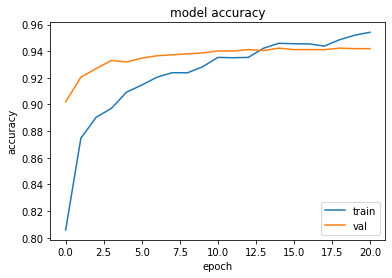

In [23]:
fig_acc = plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')

In [24]:
model2.evaluate(test_set)

188/188 [==============================] - 15s 80ms/step - loss: 0.1945 - accuracy: 0.9333


[0.19448256492614746, 0.9333333373069763]

In [25]:
evalPipe=test_set
for feats,lab in evalPipe.unbatch().batch(6000).take(1):
	probPreds=model2.predict(feats)

top1err=tf.reduce_mean(keras.metrics.sparse_top_k_categorical_accuracy(lab,probPreds,k=1))
top5err=tf.reduce_mean(keras.metrics.sparse_top_k_categorical_accuracy(lab,probPreds,k=5))
top10err=tf.reduce_mean(keras.metrics.sparse_top_k_categorical_accuracy(lab,probPreds,k=10))
print(top10err, top5err, top1err)

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.9993333, shape=(), dtype=float32) tf.Tensor(0.93333334, shape=(), dtype=float32)
